In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from concurrent.futures import ThreadPoolExecutor

from yellowbrick.classifier import ConfusionMatrix

import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
def convert_to_integer(value): # Function to cover the cases where there are multiple dbm_antsignal values.
    if pd.isna(value) or value == '':
        return None 
    elif isinstance(value, int) or isinstance(value, float):
        return value
    else:
        signal_strengths = [int(v) for v in value.split('-') if v]
        if signal_strengths:
            average_strength = round(sum(signal_strengths) / len(signal_strengths))
            return -average_strength
        else:
            return None

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
selected_features = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'radiotap.channel.freq', 'radiotap.channel.flags.cck', 'radiotap.channel.flags.ofdm', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected']
main_folder_path = "D:/AWID/CSV"
columns_to_read = selected_features + ['Label']
included_directories = ["1.Deauth", "2.Disas", "3.(Re)Assoc", "6.Kr00k", "4.Rogue_AP", "12.Evil_Twin", "5.Krack"]

csv_files = glob.glob(f"{main_folder_path}/**/*.csv", recursive=True)

def read_csv(file):
    return pd.read_csv(file, usecols=columns_to_read)

# Use ThreadPoolExecutor for parallel file reading
with ThreadPoolExecutor(max_workers=2) as executor:  # Adjust max_workers based on your CPU
    dfs = list(executor.map(read_csv, [file for directory in included_directories for file in glob.glob(f"{main_folder_path}/{directory}/*.csv")]))

# Concatenate all DataFrames
data = pd.concat(dfs, ignore_index=True)

In [5]:
del dfs
del csv_files
data = reduce_mem_usage(data)

Memory usage of dataframe is 2020.07 MB
Memory usage after optimization is: 846.72 MB
Decreased by 58.1%


In [6]:
data

,frame.len,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.dbm_antsignal,radiotap.length,radiotap.present.tsft,wlan.duration,wlan.fc.ds,wlan.fc.frag,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,Label
0,342.0,0.0,1.0,5180.0,-34-37-34,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
1,342.0,0.0,1.0,5180.0,-34-38-34,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
2,136.0,0.0,1.0,5180.0,-34-39-34,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
3,154.0,0.0,1.0,5180.0,-34-39-34,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
4,342.0,0.0,1.0,5180.0,-35-40-35,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15574937,1542.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
15574938,1542.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
15574939,1542.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
15574940,1542.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal


### Getting rid of NaN values

In [7]:
data = data.replace(r'^\s*$', pd.NA, regex=True)
data = data.replace('?', pd.NA)
data = data.dropna()

In [8]:
data['Label'] = data['Label'].replace('Kr00K', 'Kr00k')

In [9]:
value_counts = data['Label'].value_counts()
value_counts

Label
Normal       15107347
Kr00k          191803
Evil_Twin      104827
Disas           75131
Krack           49990
Deauth          38942
(Re)Assoc        5502
RogueAP          1310
Name: count, dtype: int64

### Removing some Normal values to perform SMOTE later on

In [10]:
number_to_delete = 12_600_000
normal_indices = data[data['Label'] == 'Normal'].index
indices_to_delete = pd.Series(normal_indices).sample(n=number_to_delete, random_state=42)
data = data.drop(indices_to_delete)

In [11]:
value_counts = data['Label'].value_counts()
value_counts

Label
Normal       2507347
Kr00k         191803
Evil_Twin     104827
Disas          75131
Krack          49990
Deauth         38942
(Re)Assoc       5502
RogueAP         1310
Name: count, dtype: int64

In [12]:
X = data.loc[:, selected_features]
y = data[['Label']]

In [13]:
del data

### Data preprocessing

In [14]:
X['radiotap.dbm_antsignal'] = X['radiotap.dbm_antsignal'].apply(convert_to_integer)

In [15]:
columns_to_scale = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration']
columns_to_one_hot_encode = [col for col in X.columns if col not in columns_to_scale]

# Min-max scaling
scaler = MinMaxScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# One-hot encoding
X = pd.get_dummies(X, columns=columns_to_one_hot_encode)

In [16]:
memory_usage = X.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()
output = total_memory_usage / (1024 ** 2)

print(f"{output:.2f} MB")

224.13 MB


### Evaluation Functions

In [17]:
def evaluate_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)
    
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='micro')
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    cm = confusion_matrix(y_test, y_pred)
    
    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

In [18]:
def evaluate_classifier_linearsvc(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)

    decision_scores = classifier.decision_function(X_test)
    
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='micro')
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='macro')
    
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    cm = confusion_matrix(y_test, y_pred)
    
    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

### Training Functions

In [19]:
def train_and_eval_logistic_regression(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    logreg_model = LogisticRegression(
        solver='sag',
        max_iter=1000,
        tol=0.01,
        random_state=42,
        n_jobs=-1
    )

    logreg_model.fit(X_train, y_train)

    return evaluate_classifier(logreg_model, X_test, y_test)

In [20]:
def train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    sgd_model = SGDClassifier(
        tol=1e-05,
        loss='modified_huber',
        early_stopping=True,
        n_jobs=-1,
        random_state=42
    )

    sgd_model.fit(X_train, y_train)

    return evaluate_classifier(sgd_model, X_test, y_test)

In [21]:
def train_and_eval_linearsvc(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    svc_model = LinearSVC(max_iter=20000, C=1.5, random_state=42)

    svc_model.fit(X_train, y_train)

    return evaluate_classifier_linearsvc(svc_model, X_test, y_test)

In [22]:
def train_and_eval_lightgbm(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    params = {
        'objective': 'multiclass',
        'num_class': len(y_train.unique()),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 20,
        'learning_rate': 0.01,
        'max_bin': 20,
        'max_depth': 10,
        'min_child_samples': 30,
        'min_data_in_bin': 10,
        'min_split_gain': 0.1,
        'n_estimators': 80,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'n_jobs': -1,
        'verbose': -1
    }

    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train)

    return evaluate_classifier(lgb_model, X_test, y_test)

In [23]:
def train_and_eval_decision_tree(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    dt_model = DecisionTreeClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42
    )

    dt_model.fit(X_train, y_train)

    return evaluate_classifier(dt_model, X_test, y_test)

In [24]:
def train_and_eval_random_forest(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    rf_model = RandomForestClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)
    
    return evaluate_classifier(rf_model, X_test, y_test)

In [25]:
def train_and_eval_extra_trees(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    et_model = ExtraTreesClassifier(
        max_depth=200,
        n_estimators=200,
        ccp_alpha=0.0001,
        max_leaf_nodes=500,
        min_samples_leaf=2,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )

    et_model.fit(X_train, y_train)
    
    return evaluate_classifier(et_model, X_test, y_test)

### Printing Functions

In [26]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 10))

    #vmax = 320000
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [27]:
def print_results(name, results):
    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    print(f"\n{name}")
    
    print(f"Micro Precision: {results[0][0]}")
    print(f"Micro Recall: {results[0][1]}")
    print(f"Micro F1: {results[0][2]}")
    print(f"Micro AUC: {results[0][3]}")
    
    print(f"Macro Precision: {results[1][0]}")
    print(f"Macro Recall: {results[1][1]}")
    print(f"Macro F1: {results[1][2]}")
    print(f"Macro AUC: {results[1][3]}")
    
    print(f"Weighted Precision: {results[2][0]}")
    print(f"Weighted Recall: {results[2][1]}")
    print(f"Weighted F1: {results[2][2]}")
    print(f"Weighted AUC: {results[2][3]}")
    
    print(f"Accuracy: {results[3]}")

    plot_confusion_matrix(results[4], classes, f'Combined Confusion Matrix for {name}')

In [28]:
def print_average_results(name, results_list):
    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    print(f"\n{name}")
    
    average_precision_micro = sum(result[0][0] for result in results_list) / len(results_list)
    average_recall_micro = sum(result[0][1] for result in results_list) / len(results_list)
    average_f1_micro = sum(result[0][2] for result in results_list) / len(results_list)
    average_auc_micro = sum(result[0][3] for result in results_list) / len(results_list)

    average_precision_macro = sum(result[1][0] for result in results_list) / len(results_list)
    average_recall_macro = sum(result[1][1] for result in results_list) / len(results_list)
    average_f1_macro = sum(result[1][2] for result in results_list) / len(results_list)
    average_auc_macro = sum(result[1][3] for result in results_list) / len(results_list)

    average_precision_weighted = sum(result[2][0] for result in results_list) / len(results_list)
    average_recall_weighted = sum(result[2][1] for result in results_list) / len(results_list)
    average_f1_weighted = sum(result[2][2] for result in results_list) / len(results_list)
    average_auc_weighted = sum(result[2][3] for result in results_list) / len(results_list)
    
    average_accuracy = sum(result[3] for result in results_list) / len(results_list)

    combined_cm = None

    # Add each confusion matrix
    for result in results_list:
        if combined_cm is None:
            combined_cm = result[4]
        else:
            combined_cm += result[4]

    print("Average Micro Precision:", average_precision_micro)
    print("Average Micro Recall:", average_recall_micro)
    print("Average Micro F1:", average_f1_micro)
    print("Average Micro AUC:", average_auc_micro)

    print("\nAverage Macro Precision:", average_precision_macro)
    print("Average Macro Recall:", average_recall_macro)
    print("Average Macro F1:", average_f1_macro)
    print("Average Macro AUC:", average_auc_macro)

    print("\nAverage Weighted Precision:", average_precision_weighted)
    print("Average Weighted Recall:", average_recall_weighted)
    print("Average Weighted F1:", average_f1_weighted)
    print("Average Weighted AUC:", average_auc_weighted)
    
    print("\nAverage Accuracy:", average_accuracy)
    
    plot_confusion_matrix(combined_cm, classes, f'Combined Confusion Matrix for {name}')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Undersampling

In [30]:
#under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#X_train, y_train = under_sampler.fit_resample(X_train, y_train)

In [31]:
#value_counts = y_train['Label'].value_counts()
#value_counts

### SMOTE

In [32]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


Logistic Regression
Micro Precision: 0.9761887554183313
Micro Recall: 0.9761887554183313
Micro F1: 0.9761887554183313
Micro AUC: 0.9995258640744804
Macro Precision: 0.7871936595338878
Macro Recall: 0.9265833094437388
Macro F1: 0.8343712963098581
Macro AUC: 0.9976399226648065
Weighted Precision: 0.9770698280190306
Weighted Recall: 0.9761887554183313
Weighted F1: 0.975983504084509
Weighted AUC: 0.9987698167987019
Accuracy: 0.9761887554183313


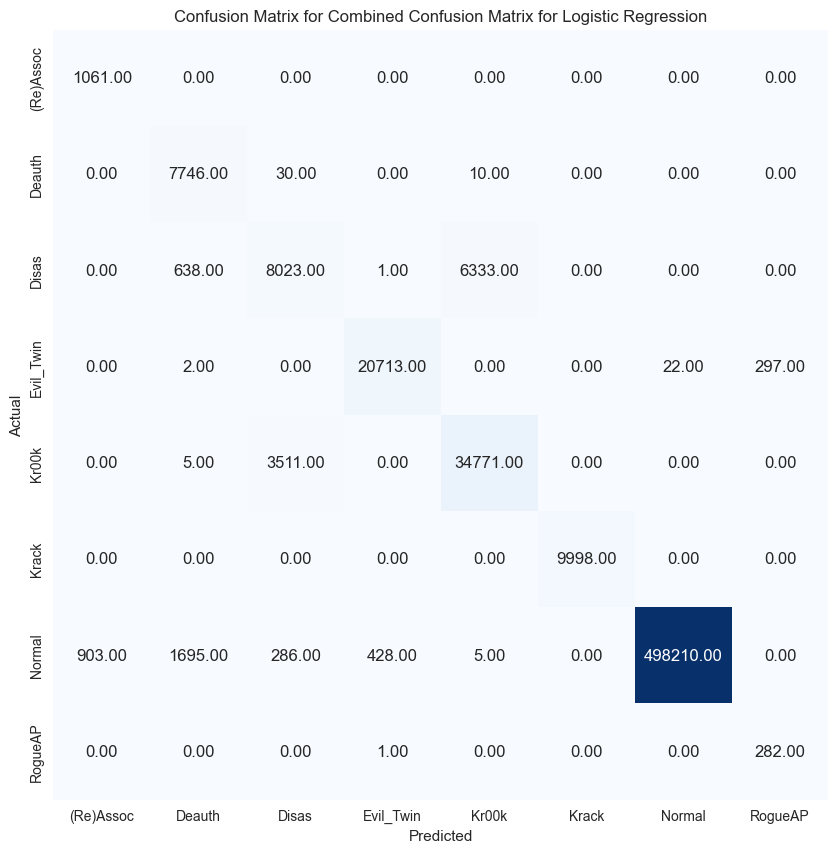

In [33]:
results = train_and_eval_logistic_regression(X_train, y_train, X_test, y_test)
print_results("Logistic Regression", results)


SGDClassifier
Micro Precision: 0.965334444872103
Micro Recall: 0.965334444872103
Micro F1: 0.965334444872103
Micro AUC: 0.9986704042462221
Macro Precision: 0.7224586415618844
Macro Recall: 0.8856909533583965
Macro F1: 0.7583683126676877
Macro AUC: 0.99318314326083
Weighted Precision: 0.9678632699791531
Weighted Recall: 0.965334444872103
Weighted F1: 0.9660050452972382
Weighted AUC: 0.9983318884506941
Accuracy: 0.965334444872103


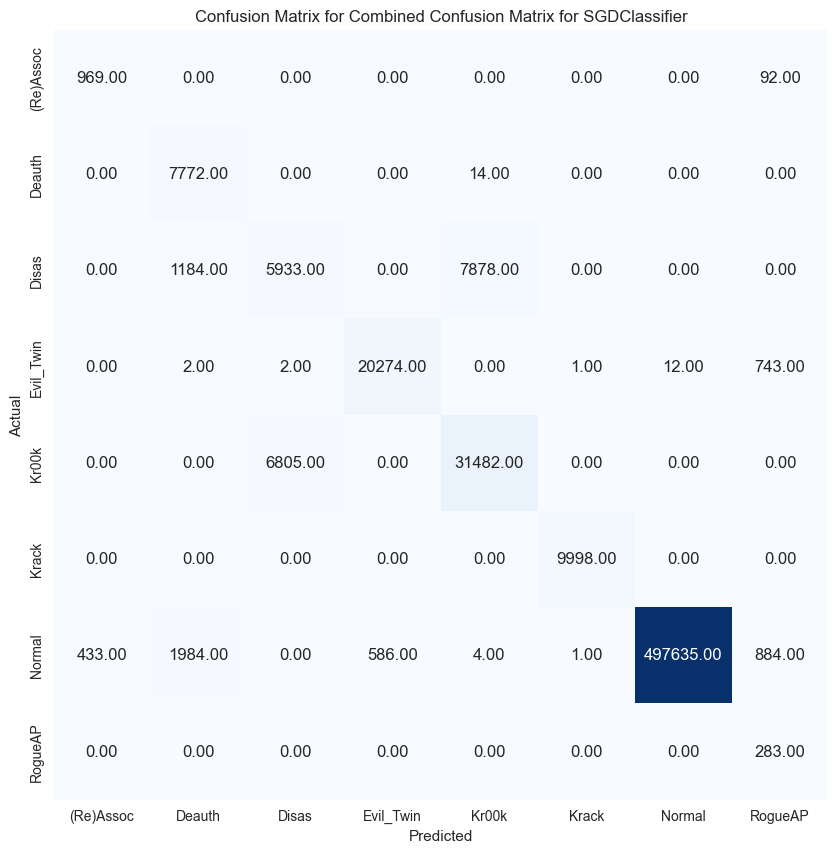

In [34]:
results = train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test)
print_results("SGDClassifier", results)

c:\Users\egkubo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



LinearSVC
Micro Precision: 0.9718255175462334
Micro Recall: 0.9718255175462334
Micro F1: 0.9718255175462334
Micro AUC: 0.9991192433891112
Macro Precision: 0.7343499513614213
Macro Recall: 0.9099866205836407
Macro F1: 0.7771069344228132
Macro AUC: 0.9969097378476379
Weighted Precision: 0.9735243420054527
Weighted Recall: 0.9718255175462334
Weighted F1: 0.971327980451896
Weighted AUC: 0.9991675076923858
Accuracy: 0.9718255175462334


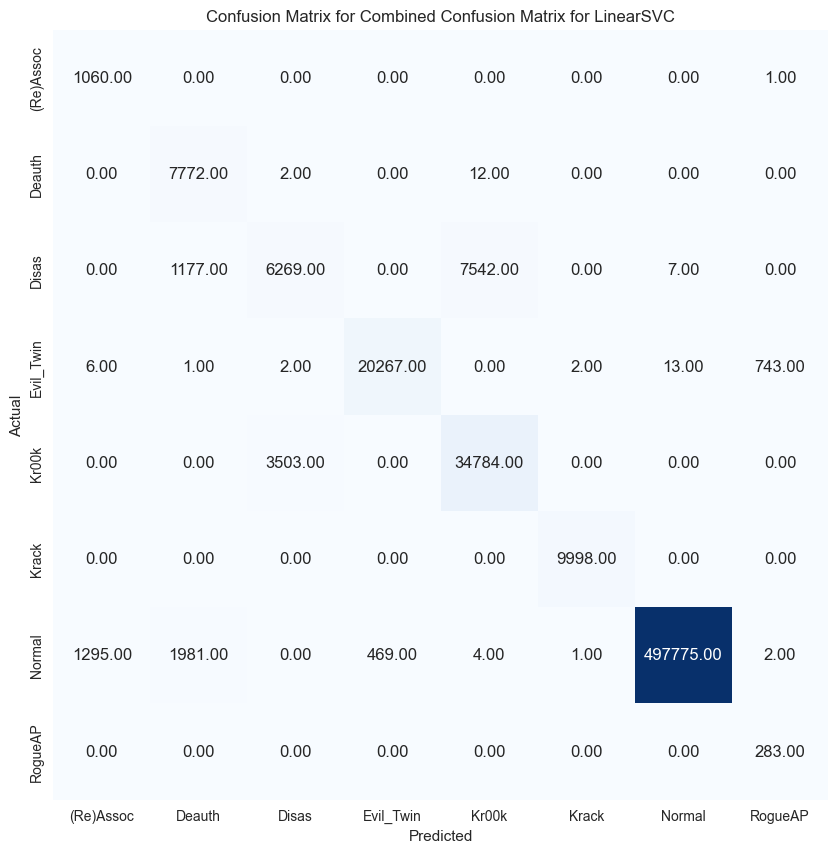

In [35]:
results = train_and_eval_linearsvc(X_train, y_train, X_test, y_test)
print_results("LinearSVC", results)


LightGBM
Micro Precision: 0.9922702114892995
Micro Recall: 0.9922702114892995
Micro F1: 0.9922702114892995
Micro AUC: 0.999908900739733
Macro Precision: 0.9621395982933305
Macro Recall: 0.9837971574878049
Macro F1: 0.9726161748470423
Macro AUC: 0.9996386157615432
Weighted Precision: 0.9925875920558899
Weighted Recall: 0.9922702114892995
Weighted F1: 0.9923794424090819
Weighted AUC: 0.9998481615653163
Accuracy: 0.9922702114892995


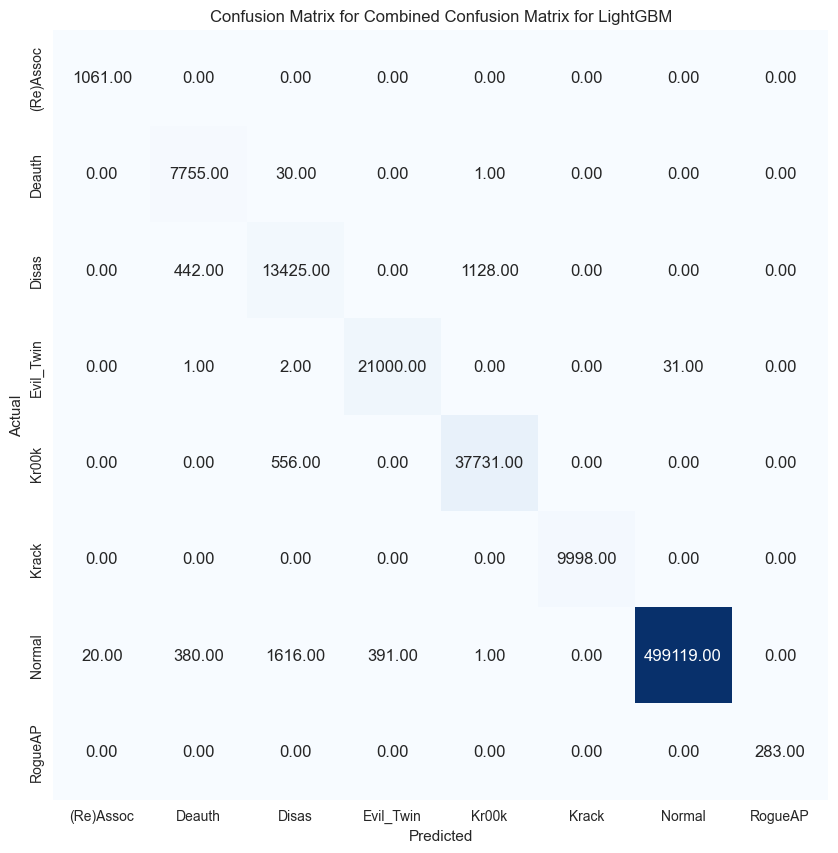

In [36]:
results = train_and_eval_lightgbm(X_train, y_train, X_test, y_test)
print_results("LightGBM", results)


Decision Tree
Micro Precision: 0.9886112096219816
Micro Recall: 0.9886112096219816
Micro F1: 0.9886112096219816
Micro AUC: 0.9995804539230377
Macro Precision: 0.8641397522910471
Macro Recall: 0.9844895731307965
Macro F1: 0.9045483938663332
Macro AUC: 0.9992118435612016
Weighted Precision: 0.9914481369848306
Weighted Recall: 0.9886112096219816
Weighted F1: 0.9895680129303986
Weighted AUC: 0.9993443819372786
Accuracy: 0.9886112096219816


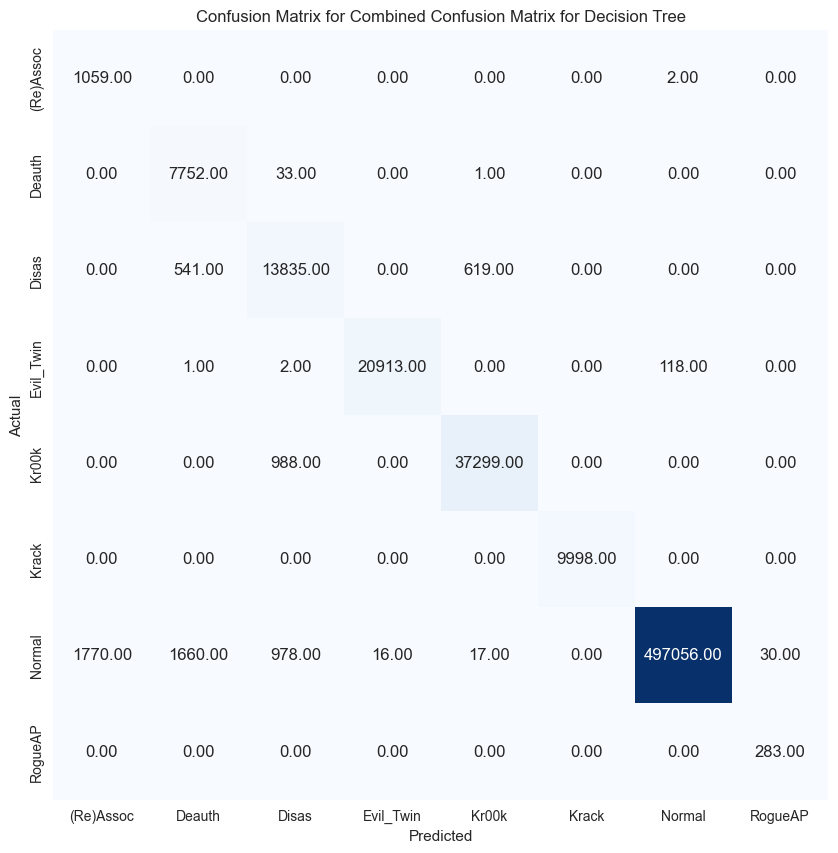

In [37]:
results = train_and_eval_decision_tree(X_train, y_train, X_test, y_test)
print_results("Decision Tree", results)


Random Forest
Micro Precision: 0.9898095873580393
Micro Recall: 0.9898095873580393
Micro F1: 0.9898095873580394
Micro AUC: 0.9996892530304293
Macro Precision: 0.8831428752168078
Macro Recall: 0.9857384855173448
Macro F1: 0.919718533364446
Macro AUC: 0.9995292976634298
Weighted Precision: 0.9918181597883473
Weighted Recall: 0.9898095873580393
Weighted F1: 0.9904437463571927
Weighted AUC: 0.9997968277264226
Accuracy: 0.9898095873580393


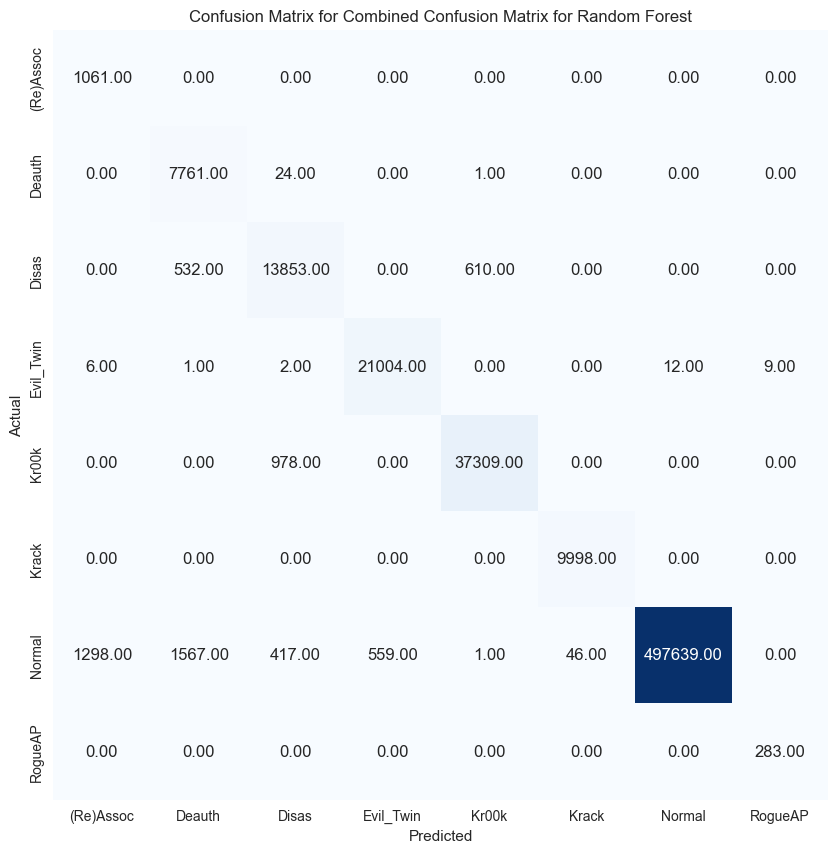

In [38]:
results = train_and_eval_random_forest(X_train, y_train, X_test, y_test)
print_results("Random Forest", results)


Extra Trees
Micro Precision: 0.9920063330817804
Micro Recall: 0.9920063330817804
Micro F1: 0.9920063330817804
Micro AUC: 0.999921241854937
Macro Precision: 0.961789151345068
Macro Recall: 0.9869367012291654
Macro F1: 0.9738848387371681
Macro AUC: 0.9994662780595935
Weighted Precision: 0.992583882490791
Weighted Recall: 0.9920063330817804
Weighted F1: 0.9922009427719543
Weighted AUC: 0.9998720919610304
Accuracy: 0.9920063330817804


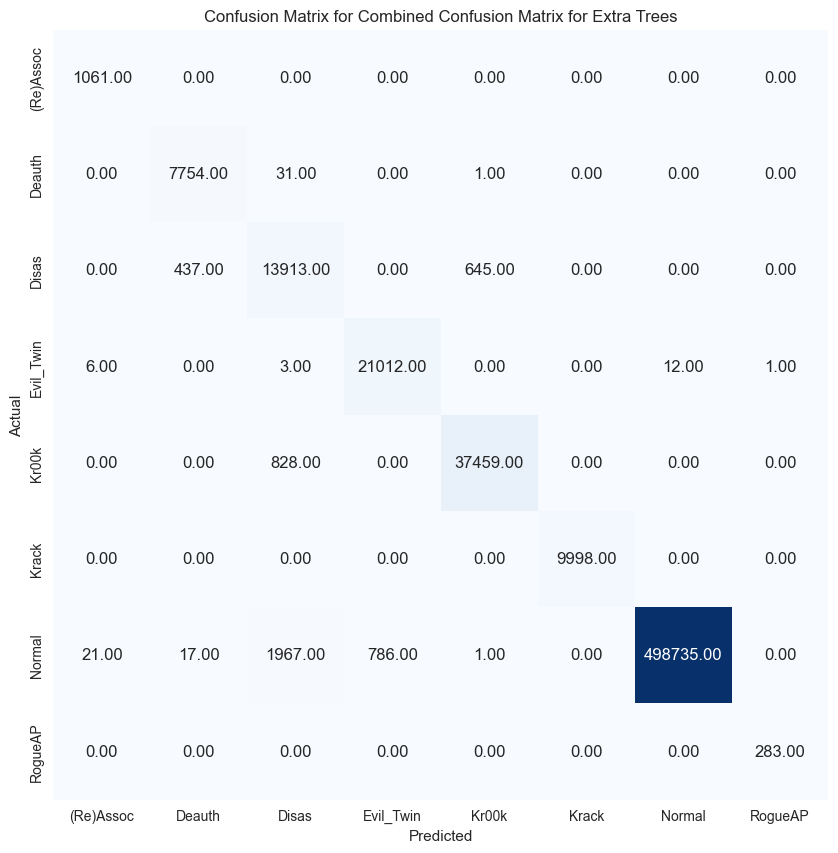

In [39]:
results = train_and_eval_extra_trees(X_train, y_train, X_test, y_test)
print_results("Extra Trees", results)

## k-fold validation

In [40]:
k_folds = 10
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

### Logistic Regression


Logistic Regression
Average Micro Precision: 0.9741950189251586
Average Micro Recall: 0.9741950189251586
Average Micro F1: 0.9741950189251586
Average Micro AUC: 0.999751877327566

Average Macro Precision: 0.8938080953300462
Average Macro Recall: 0.7730842554852375
Average Macro F1: 0.7650394541886816
Average Macro AUC: 0.9977149338109836

Average Weighted Precision: 0.9730301315607788
Average Weighted Recall: 0.9741950189251586
Average Weighted F1: 0.9723012871942085
Average Weighted AUC: 0.999290281109072

Average Accuracy: 0.9741950189251586


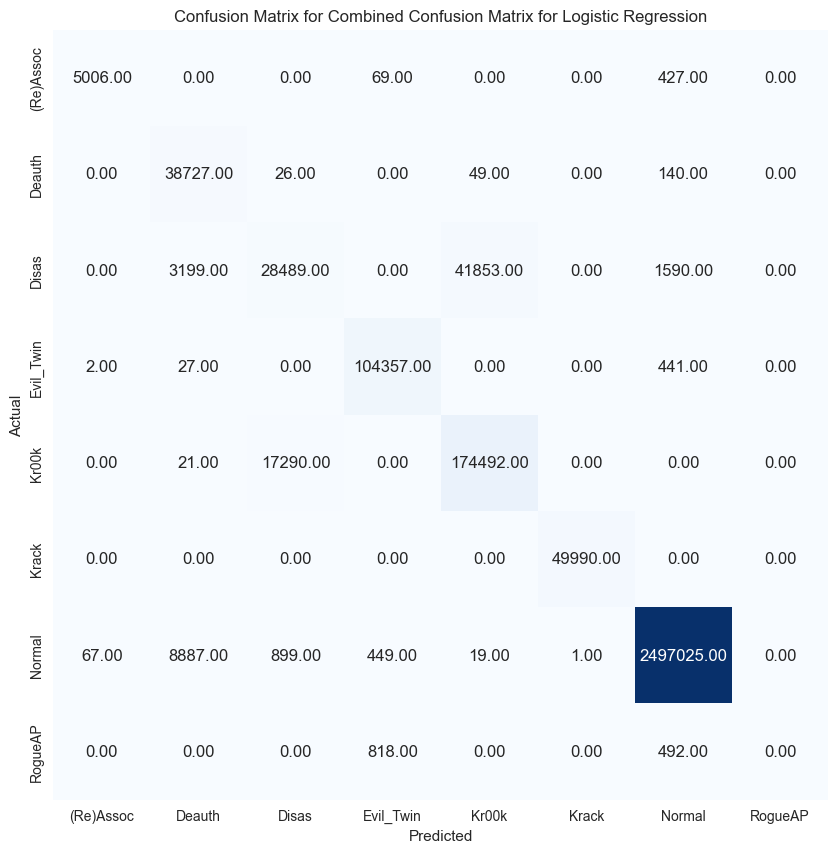

In [41]:
results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_logistic_regression(X_train, y_train, X_test, y_test)
    
    results_list.append(results)

print_average_results("Logistic Regression", results_list)

### SGDClassifier


SGDClassifier
Average Micro Precision: 0.9737207098938578
Average Micro Recall: 0.9737207098938578
Average Micro F1: 0.9737207098938578
Average Micro AUC: 0.9991570357340253

Average Macro Precision: 0.892052524346132
Average Macro Recall: 0.7698760958447652
Average Macro F1: 0.7587378025376146
Average Macro AUC: 0.9942709474843273

Average Weighted Precision: 0.9733466916922309
Average Weighted Recall: 0.9737207098938578
Average Weighted F1: 0.9715350821251267
Average Weighted AUC: 0.9985907263511283

Average Accuracy: 0.9737207098938578


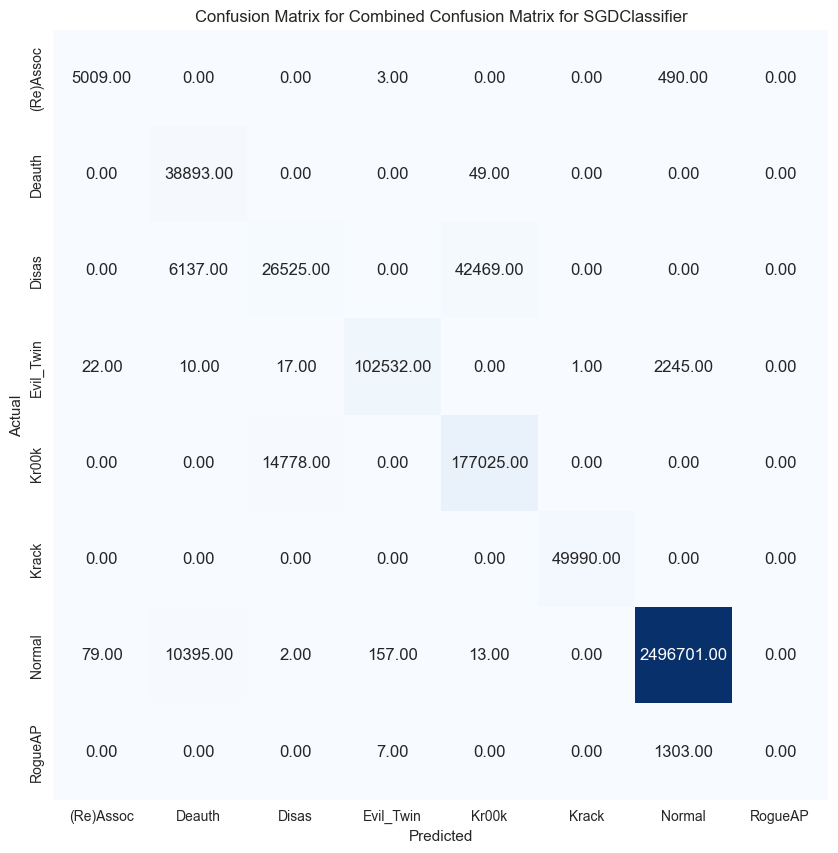

In [42]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("SGDClassifier", results_list)

### LinearSVC

In [43]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_linearsvc(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("LinearSVC", results_list)

c:\Users\egkubo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\egkubo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### LightGBM

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_lightgbm(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("LightGBM", results_list)

### Decision Tree


Decision Tree
Average Micro Precision: 0.9975279379788299
Average Micro Recall: 0.9975279379788299
Average Micro F1: 0.9975279379788299
Average Micro AUC: 0.9999791707661322

Average Macro Precision: 0.9653688488229198
Average Macro Recall: 0.6926866001963183
Average Macro F1: 0.7020743709853898
Average Macro AUC: 0.9970215901881391

Average Weighted Precision: 0.9975581376215008
Average Weighted Recall: 0.9975279379788299
Average Weighted F1: 0.9972415848982337
Average Weighted AUC: 0.9993185189424851

Average Accuracy: 0.9975279379788299


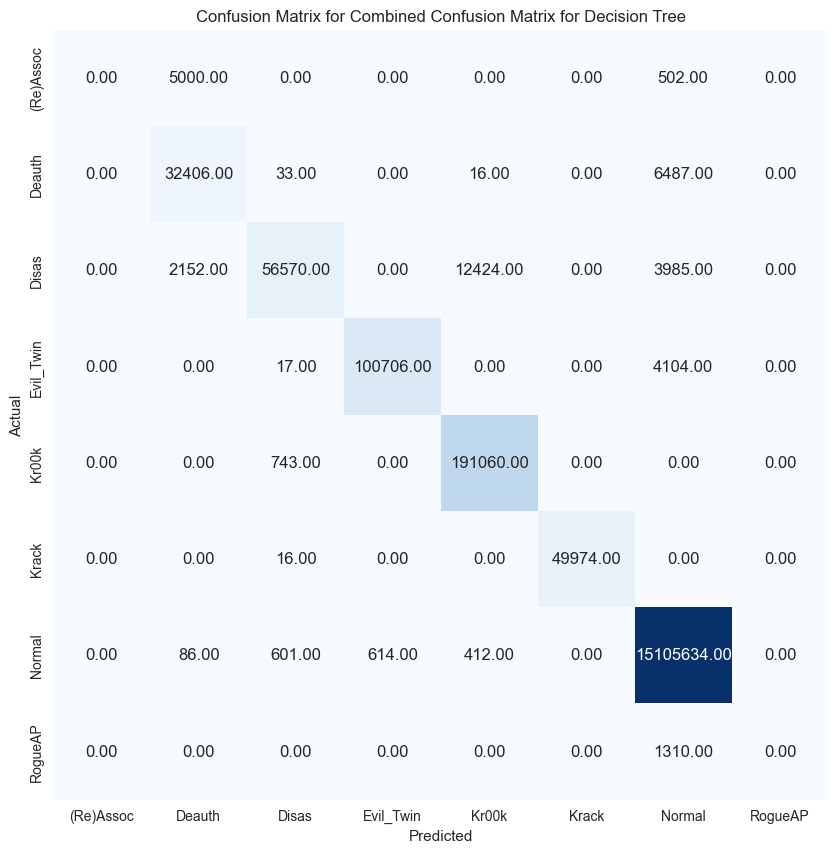

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_decision_tree(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Decision Tree", results_list)

### Random Forest

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_random_forest(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Random Forest", results_list)

### Extra Trees

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    results = train_and_eval_extra_trees(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Extra Trees", results_list)